---
# Sentiment Analysis from Tweets
---
 Given a tweet or short text, the goal is to predict the emotion category the text expresses. There are 3 categories: positve, netural, and negative.

## Dataset




---
# SETUP
---

**Import Dependencies**

In [3]:
import os
import re
import sys
import time
import gc
from tqdm import tqdm
import numpy as np

# import torch
# import torch.nn as nn
# import tensorflow as tf
# from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig
# from torch.utils.data import TensorDataset, random_split, DataLoader
# from torch.utils.data import RandomSampler, SequentialSampler
# from transformers import get_linear_schedule_with_warmup

**Color Palette Specifications**

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots
%matplotlib inline

palette_color  = sns.color_palette("pastel",10)
sns.set_theme(style="whitegrid", palette=palette_color)

palette_color

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

**Pandas Specifications**

In [4]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.precision = 0
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Change Current Working Directory**

In [5]:
# Get the current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Change the working directory to a specific path
os.chdir('/mnt/d/ai/WideBotAI')

# Verify the change
current_dir = os.getcwd()
print(f"New working directory: {current_dir}")

if not 'WideBotAI' in sys.path:
    sys.path += ['WideBotAI']

Current working directory: /mnt/d/ai/WideBotAI/Sentiment-Analysis
New working directory: /mnt/d/ai/WideBotAI


<a id="1.3"></a>
## Using GPU

In [7]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


---
## Load in the emotions dataset and provide basic statistics of the dataset.
---

## Load Datasets

In [ ]:
train_df = pd.read_json("train.json", lines=True)
train_df.shape

(16000, 2)

In [ ]:
val_df = pd.read_json("validation.json", lines=True)
val_df.shape

(2000, 2)

In [ ]:
test_df = pd.read_json("test.json", lines=True)
test_df.shape

(2000, 2)

## Check Missing Text

In [ ]:
train_df['text'].isna().sum()
val_df['text'].isna().sum()
test_df['text'].isna().sum()

0

0

0

## Check Duplication

In [ ]:
train_df['text'].duplicated().sum()
val_df['text'].duplicated().sum()
test_df['text'].duplicated().sum()

31

2

0

In [ ]:
val_df[val_df['text'].duplicated(keep=False)]

text   
300   i have had several new members tell me how comfortable they feel with how accepted they are by the existing members and that is great to hear  \
603   i have had several new members tell me how comfortable they feel with how accepted they are by the existing members and that is great to hear   
774                                                                                                                        i feel so tortured by it   
1993                                                                                                                       i feel so tortured by it   

      label  
300       2  
603       1  
774       4  
1993      3

In [ ]:
train_df[train_df['text'].duplicated(keep=False)]

text   
364                                                                                                                                         i tend to stop breathing when i m feeling stressed  \
1501                                                                         i feel on the verge of tears from weariness i look at your sweet face and cant help but tenderly kiss your cheeks   
1625   i was intensely conscious of how much cash i had left in my gas and food envelope and i still have what i intended to save for next week which helps me not feel so stressed and scared   
1802                                                                                                                                                          i still feel completely accepted   
2908                                                                                                                                im still not sure why reilly feels the need to be so weird   
2949                                                                 i shy away from songs that talk about how i feel toward god or that maybe even talk about my faithful response toward god   
3508                                                                                                                   i am not amazing or great at photography but i feel passionate about it   
4476                                                                                                                                                     i still feel a craving for sweet food   
4602                                                                                                                 i often find myself feeling assaulted by a multitude of sense impressions   
4776                                                                        i had to choose the sleek and smoother feel of the sweet revenge made drawing and handling the blaster a bit nicer   
4975                                                                                                                            i feel more adventurous willing to take risks img src http cdn   
5067                                                                         i feel on the verge of tears from weariness i look at your sweet face and cant help but tenderly kiss your cheeks   
5277                                                                                                                                         i began to feel accepted by gaia on her own terms   
5299                                                                  i feel pretty weird blogging about deodorant but im a bit of a deodorant snob and find it really hard to find a good one   
5400                                                                                                                                        i have chose for myself that makes me feel amazing   
5905                                               i resorted to yesterday the post peak day of illness when i was still housebound but feeling agitated and peckish for brew a href http pics   
6133                                                                                                                                                     i still feel a craving for sweet food   
6563                                                                                                                                        i tend to stop breathing when i m feeling stressed   
7333                                               i feel like i am very passionate about youtube and so id quite like to explain why i think youtube is the next best thing for entertainment   
7578                                                                                                       i feel a remembrance of the strange by justin aryiku falls into the latter category   
7582                                      i was so stubborn and that it took you getting hurt for me to admit ev

<a ><font size="3"><b>OBSERVATION:</b></font></a>
> These duplicated texts each have an exclusive label. After reading them, I realized that the first one is the correct one, thus I'll drop out the duplicates and keep the first one.

In [ ]:
train_df.drop_duplicates(subset='text', keep='first', inplace=True)
val_df.drop_duplicates(subset='text', keep='first', inplace=True)

train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [ ]:
train_df['text'].duplicated().sum()
val_df['text'].duplicated().sum()
test_df['text'].duplicated().sum()

0

0

0

### <font color = 'green'>(1) How many tweets (sentences) was used to train, test and validation?
Answering this quesion should be after drop the duplicated text, So:
 

In [ ]:
print(f"There are {len(train_df)} sentences in the training set")
print(f"There are {len(val_df)} sentences in the validation set")
print(f"There are {len(test_df)} sentences in the testing set")

There are 15969 sentences in the training set
There are 1998 sentences in the validation set
There are 2000 sentences in the testing set



### <font color = 'green'>(2) Show 5 samples from the dataset


In [ ]:
train_df.sample(5)

index   
3994    3994  \
1517    1517   
5795    5796   
102      102   
12893  12912   

                                                                                                                                                                                                                                                                    text   
3994   is name in the opening passages saying it may strike the reader as rather singular and far fetched but he may feel assured that it was by no means far fetched and that the circumstances were such that it would have been impossible to give him any other name  \
1517                                                                                      i love autumn and everything that comes with it although i feel i am getting excited for christmas way too early this year me and my friends including a href http andthenwear   
5795                                                                                                                                             i know that its hard cos you might feel helpless or anything but sometimes its something that is beyond what you can do   
102                                                                                                                                                                               i feel excited about what im doing again i feel like i have a ton of catching up to do   
12893                                                                                                                                                                                                                                             i cant feel complacent   

       label  
3994       1  
1517       1  
5795       0  
102        1  
12893      1

In [ ]:
val_df.sample(5)

index   
182     182  \
1559   1560   
197     197   
1936   1937   
496     496   

                                                                                                                                                                         text   
182                               i mean if someone wrote fanfiction about my book and made my villain gay for say druian i d be sitting there reading it and feeling furious  \
1559                                                                                                                                    im feeling pretty pleased with myself   
197   i feel so cool like ice t huhwe neun gatda beoryeo priceless sesang ye ban bani namja neottaemune na ulji anha gucha hage neoreul jabgeo na mae dallil ireun jeoldae no   
1936                                                            im trying to regroup after anatomy as ive been feeling depressed and exhausted for the past three weeks or so   
496                                                                     i woke up feeling ecstatic for about seconds and then reality hit and it just made me all upset again   

      label  
182       3  
1559      1  
197       1  
1936      0  
496       1

In [ ]:
test_df.sample(5)

text   
1024  i did enjoy the book however and i especially liked the characters of the brothers one fired up with the detectin spirit and the other feeling skeptical but willing to back his brother in a fight  \
1779                             i have some great friends and great housemates who have listened to how i feel and reminded me that its so unimportant and i should enjoy my life and be proud of myself   
1121                                                                                                                          i look at their situation and feel so so jealous that i almost cant bear it   
626                                                                                                                      i remember feeling so frightened that i could feel emotions at that high a level   
1621                                                   i feel that poachers and others who kill animals for their pelts ivory or other parts should be punished severely i find hunting and fishing cruel   

      label  
1024      4  
1779      0  
1121      3  
626       4  
1621      0

### <font color = 'green'>(3) What are the target predict labels?
Based on the information provided from the [original source](https://huggingface.co/datasets/dair-ai/emotion/viewer/split/train?row=6):

* 0: sadness
* 1: joy
* 2: love
* 3: anger
* 4: fear
* 5: surprise

In [ ]:
train_df['label'].unique()

labels = {0:'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
train_df['label_name'] = train_df.label.map(labels)
val_df['label_name'] = val_df.label.map(labels)
test_df['label_name'] = test_df.label.map(labels)

train_df['label_name'].unique()

array([0, 3, 2, 5, 4, 1])

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

### <font color = 'green'>(4) What are the distributions of labels in train, test, and validation
    

In [ ]:
# Let's visualize the sentiments
def Check_balance(df):
    
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    
    labels_counts = df.groupby(['label_name']).size().sort_values(ascending = False)
    labels_counts = labels_counts.to_frame(name='count')
    labels_counts['proportion'] = labels_counts.apply(lambda x: (x['count']/labels_counts['count'].sum())*100, axis=1)

    axs[0].pie(labels_counts['count'], labels=labels_counts.index,
               colors=palette_color, autopct='%1.2f%%', pctdistance=1.2,
               labeldistance=1.5, textprops={'fontsize': 9})

    sns.barplot(x = labels_counts.index, y = labels_counts['count'], ax=axs[1],palette=palette_color)

    axs[1].set_xlabel('', fontsize=12, rotation= 60)
    axs[1].set_ylabel('', fontsize=12)

    plt.tight_layout(h_pad =0.5, pad=3)
    plt.show()
    
    return labels_counts

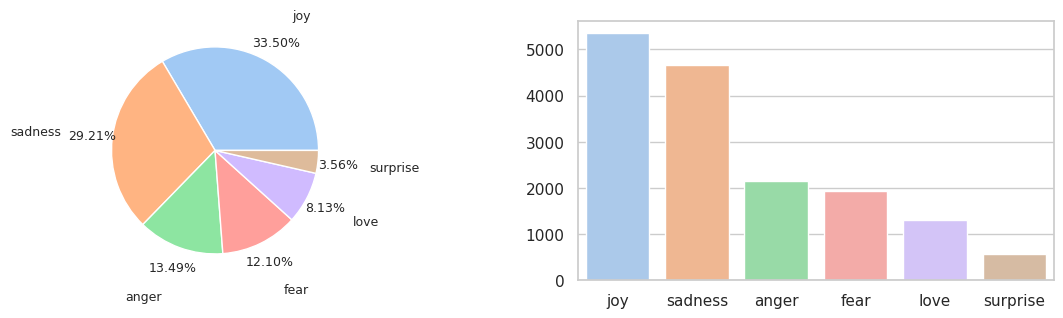

In [ ]:
train_res = Check_balance(train_df )

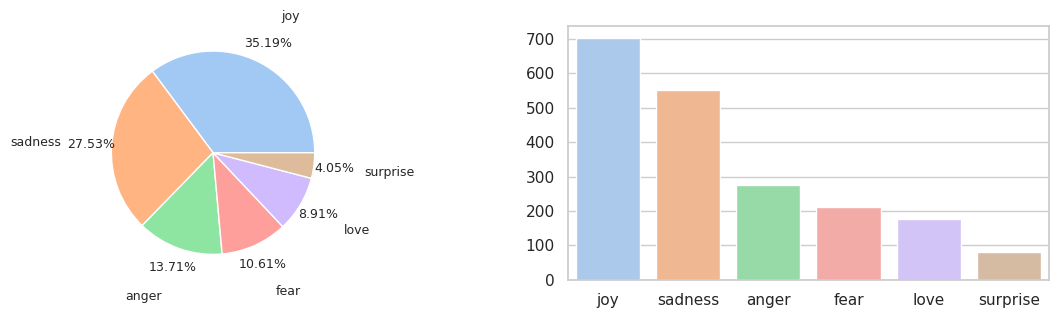

In [ ]:
val_res = Check_balance(val_df )

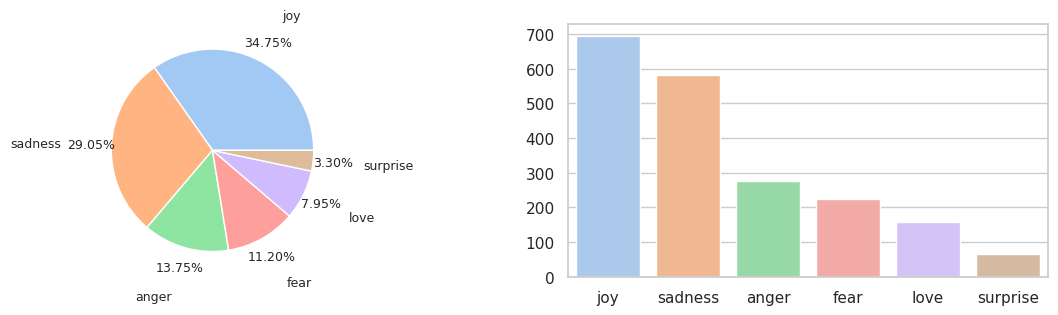

In [ ]:
test_res = Check_balance(test_df )

In [ ]:
train_res
val_res
test_res

count  proportion
label_name                   
joy          5350     33.5024
sadness      4664     29.2066
anger        2155     13.4949
fear         1933     12.1047
love         1299      8.1345
surprise      568      3.5569

count  proportion
label_name                   
joy           703     35.1852
sadness       550     27.5275
anger         274     13.7137
fear          212     10.6106
love          178      8.9089
surprise       81      4.0541

count  proportion
label_name                   
joy           695     34.7500
sadness       581     29.0500
anger         275     13.7500
fear          224     11.2000
love          159      7.9500
surprise       66      3.3000

<a ><font size="3"><b>OBSERVATION:</b></font></a>

- In all three sets, `joy` is the most common emotion, followed by `sadness`, `anger`, `fear`, `love`, and `surprise`.
- The distribution of labels in the training set is similar to that in the validation and test sets.
- There are some imbalances in the training set, with more tweets in the `sadness` and `joy` categories than in the `fear` and `surprise` categories.
- The datasets do not appear to be balanced across the 6 classes. The `joy` class is substantially overrepresented while the `surprise` class is underrepresented.

### <font color = 'green'>(5) Analyze the words per tweet in the train, test, validation.


In [ ]:
def count_words(text):
    return len(text.split())

In [ ]:
train_df['num_words'] = train_df['text'].apply(count_words)
test_df['num_words'] = test_df['text'].apply(count_words)
val_df['num_words'] = val_df['text'].apply(count_words)

# Calculate mean words per tweet by class
print('================ Training Dataset ================')
print(train_df.groupby('label').num_words.mean())     
print('=============== Validation Dataset ===============')
print(val_df.groupby('label').num_words.mean()) 
print('================= Testing Dataset ================')
print(test_df.groupby('label').num_words.mean()) 


print('\n===== The mean words per tweet in each dataset ====')
print(f"Training set: Mean words per tweet = {train_df['num_words'].mean():.2f}")
print(f"Test set: Mean words per tweet = {test_df['num_words'].mean():.2f}")
print(f"Validation set: Mean words per tweet = {val_df['num_words'].mean():.2f}")

================ Training Dataset ================
label
0   18.3591
1   19.5030
2   20.7206
3   19.2394
4   18.8401
5   20.0528
Name: num_words, dtype: float64
=============== Validation Dataset ===============
label
0   18.1836
1   19.0455
2   20.5506
3   19.2482
4   18.5330
5   17.8765
Name: num_words, dtype: float64
================= Testing Dataset ================
label
0   19.0396
1   19.2475
2   19.9560
3   19.4364
4   18.0670
5   19.7576
Name: num_words, dtype: float64

===== The mean words per tweet in each dataset ====
Training set: Mean words per tweet = 19.17
Test set: Mean words per tweet = 19.15
Validation set: Mean words per tweet = 18.87


<a ><font size="3"><b>OBSERVATION:</b></font></a>
- These results suggest that the tweets in the dataset are relatively short, with an average length of around 19 words per tweet. 
- The variation in mean words per tweet between the classes is relevant.
This information can be useful in selecting appropriate text processing methods, such as setting the maximum sequence length

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stop_words =list(STOPWORDS)

def CloudWords(df):
    n_col = 3
    fig, axs = plt.subplots(2,n_col, figsize=(22,15))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    for i, label in enumerate(df.label_name.unique()):
        row = i // n_col
        col = i % n_col
        
        tweets = df[df["label_name"] == label]['text']
        text = ' '.join(tweets)
        
        wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=STOPWORDS, max_font_size=150).generate(text)
        
        axs[row, col].imshow(wordcloud, interpolation="bilinear")
        axs[row, col].set_title(f"{label} Tweets".title(), fontsize = 14)
        axs[row, col].axis("off")
    plt.show()

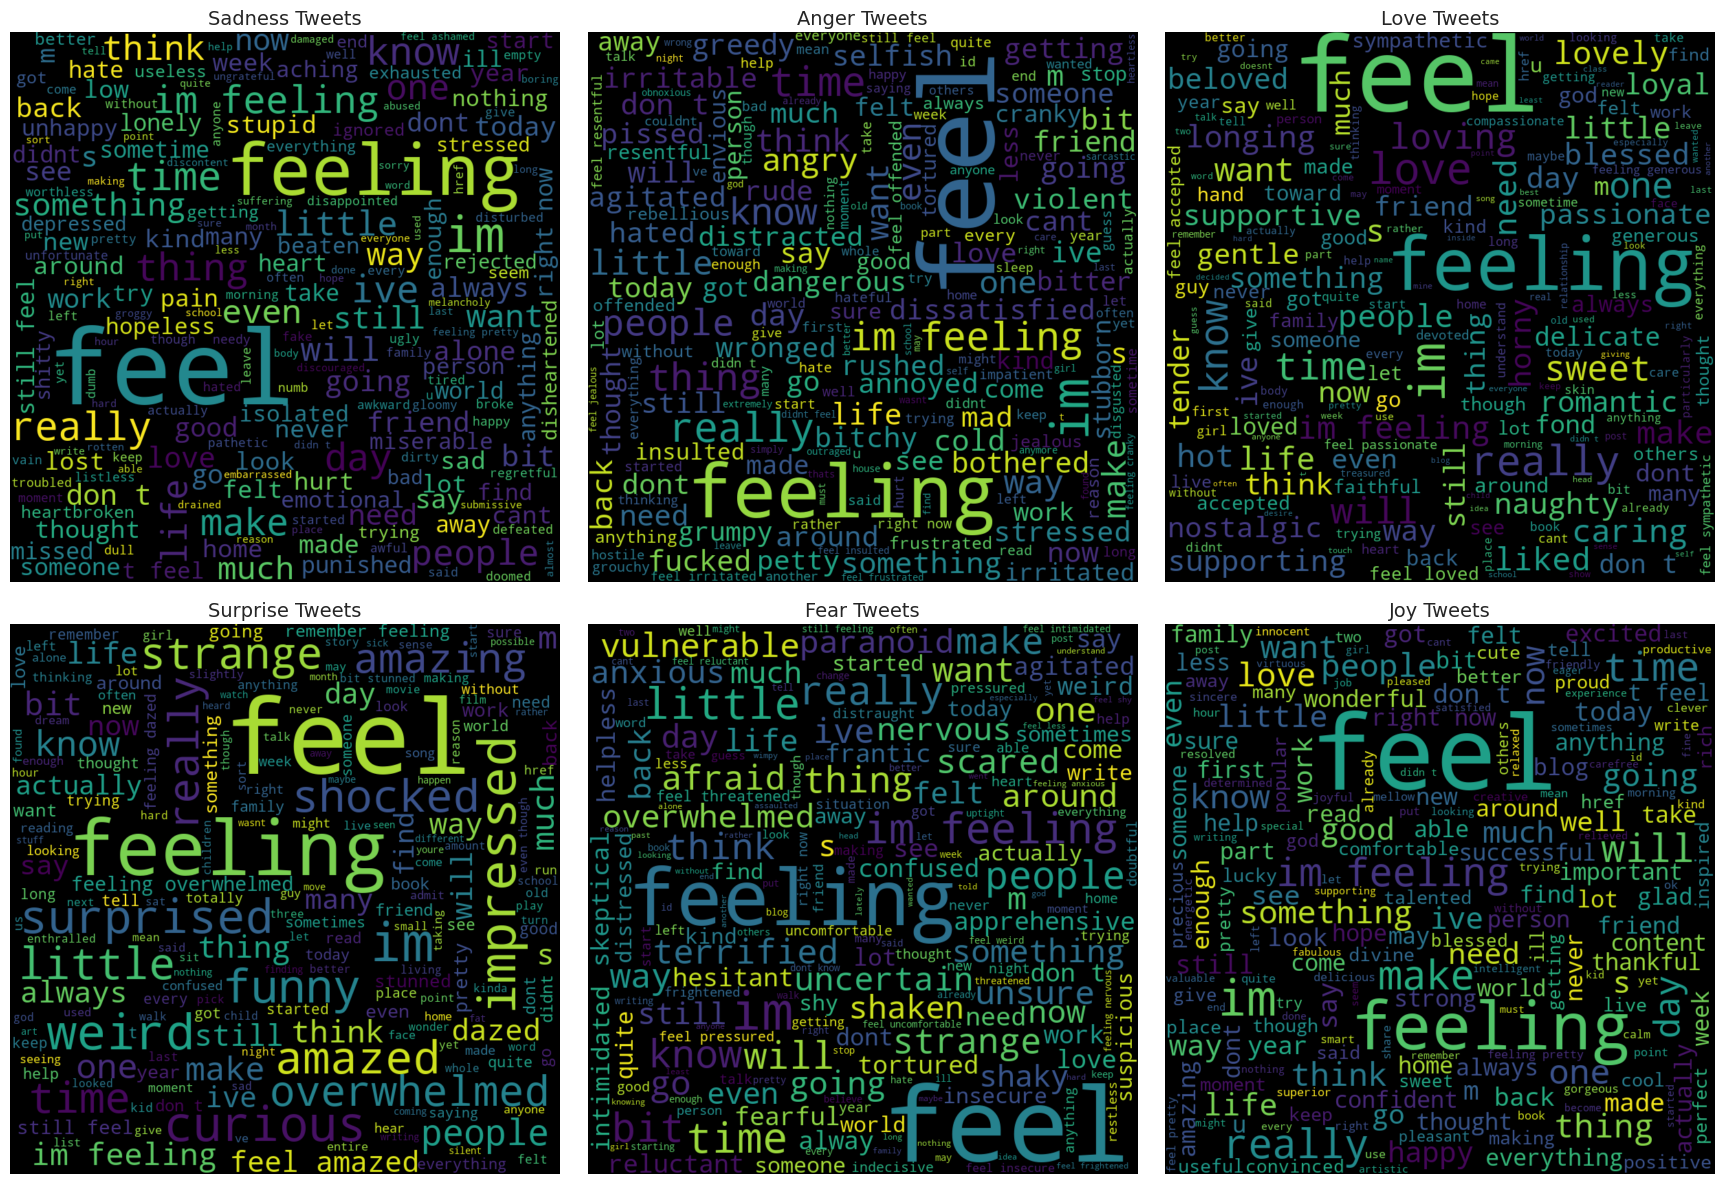

In [ ]:
CloudWords(train_df)

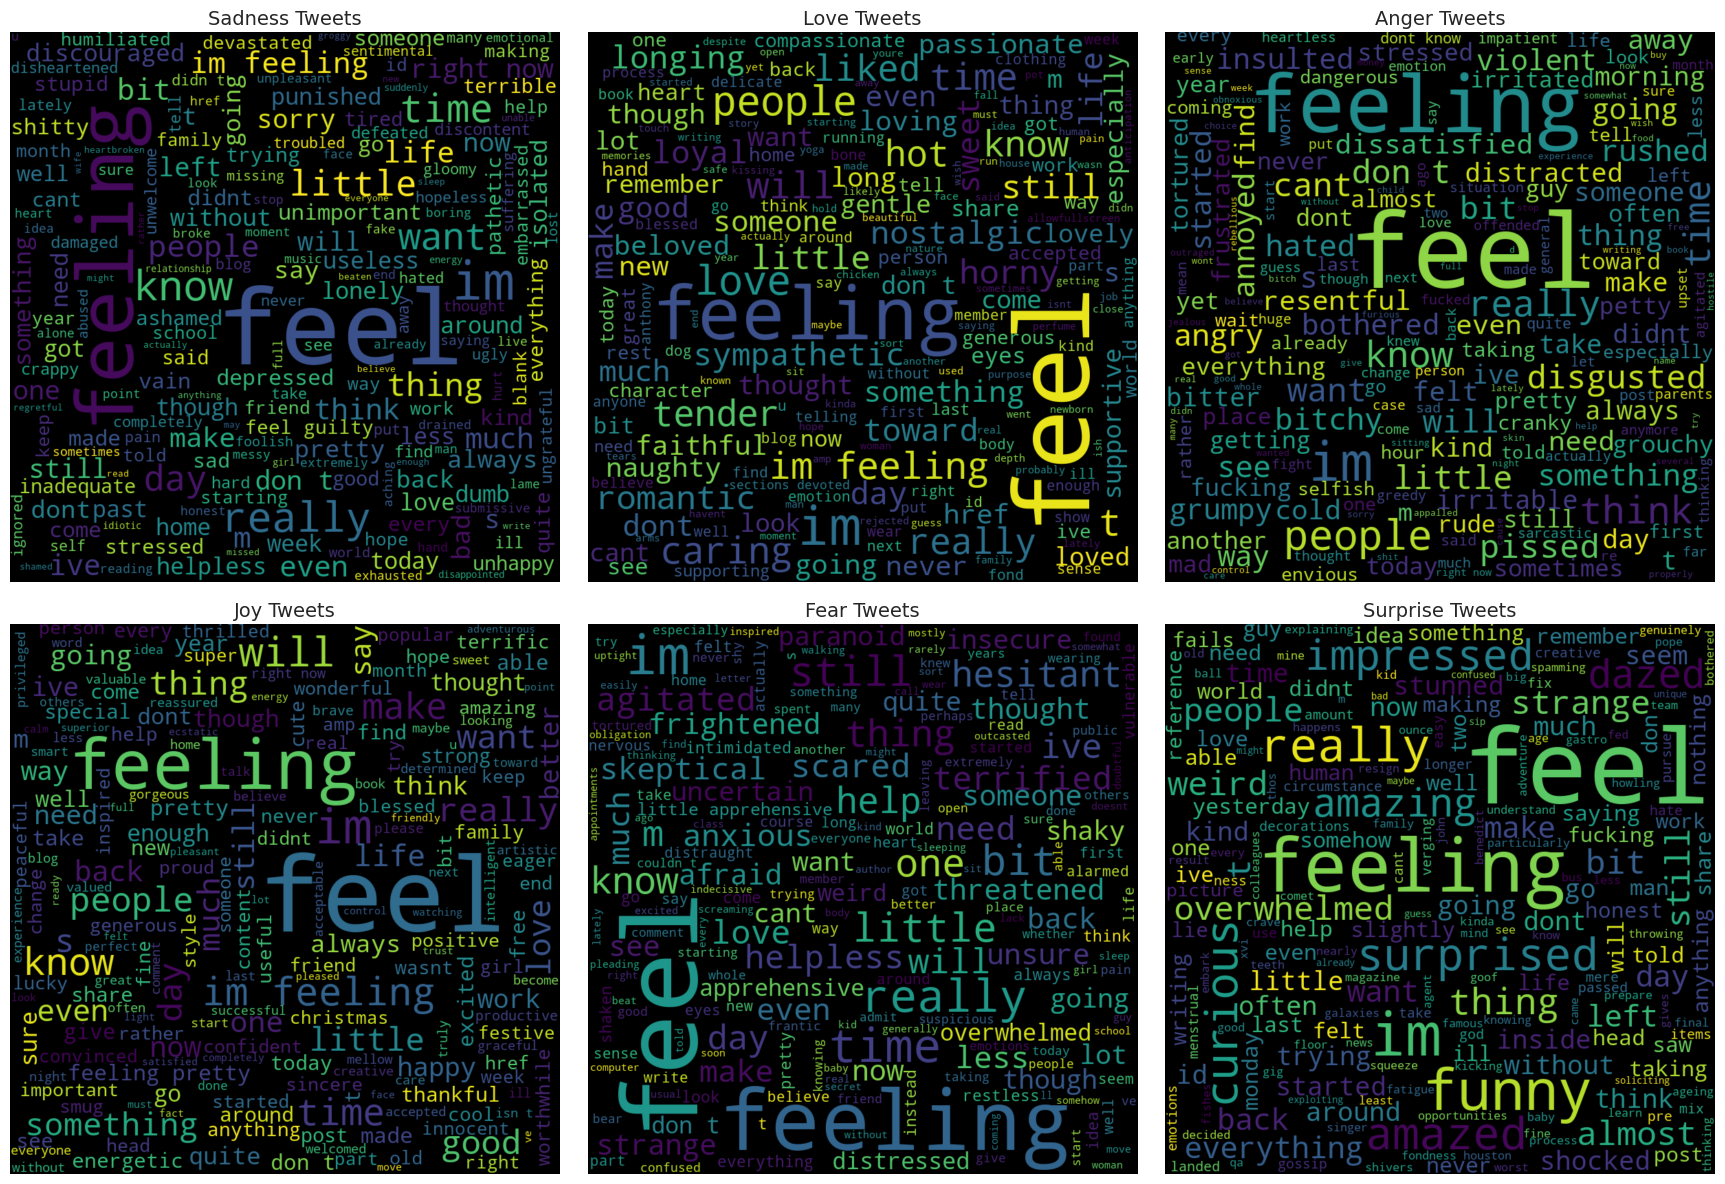

In [ ]:
CloudWords(val_df)

In [ ]:
CloudWords(test_df)

## Summarize your answers to Q1 below, based on the analysis:

### <font color = 'green'>(1) How many tweets (sentences) was used to train, test and validation?
- There are 15969 sentences in the training set
- There are 1998 sentences in the validation set
- There are 2000 sentences in the testing set
    
### <font color = 'green'>(2) Show 5 samples from the dataset
- The samples is shown above.
    
### <font color = 'green'>(3) What are the target predict labels?
Based on the information provided from the [original source](https://huggingface.co/datasets/dair-ai/emotion/viewer/split/train?row=6):

* 0: sadness
* 1: joy
* 2: love
* 3: anger
* 4: fear
* 5: surprise
    
### <font color = 'green'>(4) What are the distributions of labels in train, test, and validation

- In all three sets, `joy` is the most common emotion, followed by `sadness`, `anger`, `fear`, `love`, and `surprise`.
- The distribution of labels in the training set is similar to that in the validation and test sets.
- There are some imbalances in the training set, with more tweets in the `sadness` and `joy` categories than in the `fear` and `surprise` categories.
- The datasets do not appear to be balanced across the 6 classes. The `joy` class is substantially overrepresented while the `surprise` class is underrepresented.
    
### <font color = 'green'>(5) Analyze the words per tweet in the train, test, validation.
- These results suggest that the tweets in the dataset are relatively short, with an average length of around 19 words per tweet. 
- The variation in mean words per tweet between the classes is relevant.
This information can be useful in selecting appropriate text processing methods, such as setting the maximum sequence length
    

<a id="3"></a>

---
# TEXT PREPROCESSING
---

## Check Input Data Format

In [ ]:
def Check_format(df, check_words):
    
    for w in check_words:
        check = df[df['text'].str.contains(w, case=False)]['text']
        if not check.empty:
            print(f"Word `{w}` exist in the dataset, here is an sample: \n")
            print(check.values[0])
            print("-"*80)
        else:
            print(f"Word `{w}` not in the dataset\n")
            check_words.remove(w)
    return check_words

### Check for special characters

In [ ]:
# Select rows where the text column contains a special character
train_df[train_df.text.str.contains(r"[^a-zA-Z0-9\s]")]

Empty DataFrame
Columns: [index, text, label, label_name, num_words]
Index: []

### Check for punctuation marks

In [ ]:
# Select rows where the text column contains any punctuation mark
train_df[train_df["text"].str.contains(r"[.,?!;:\-\(\)\[\]\{\}/\"'…]")]

Empty DataFrame
Columns: [index, text, label, label_name, num_words]
Index: []

### Check fore single characters

In [ ]:
single_char_matches = train_df[train_df["text"].str.contains(r"\b[t|s|m|d|y|ve|ll|re]\b", regex = True)]
single_char_matches.iloc[100,0]
single_char_matches.shape
train_df.shape

1006

(1511, 5)

(15969, 5)

In [ ]:
single_char_matches = train_df[train_df["text"].str.contains(r"\b[t|s|m|d|y|ve|ll|re]\b", regex = True)]
single_char_matches.iloc[100,0]
single_char_matches.shape
train_df.shape

1006

(1511, 5)

(15969, 5)

### Check the negative format

In [ ]:
InteractiveShell.ast_node_interactivity = 'last_expr'
words1 = [" cant ", " couldnt ", " shouldnt ", " isnt ", " aint ", " arent ",
         " doesnt ", " didnt ", " didnt ", " hasnt ", " hadnt ", " maynt ", " mightnt ",
         " mustnt ", " neednt ", " oughtnt ", " shant ", " wont ", " wasnt "," werent "]
    
words1 = Check_format(train_df, words1)
print("#"*80)
print(words1)

Word ` cant ` exist in the dataset, here is an sample: 

i was feeling so discouraged we are already robbing peter to pay paul to get our cow this year but we cant afford to not get the cow this way
--------------------------------------------------------------------------------
Word ` couldnt ` exist in the dataset, here is an sample: 

i couldnt help but feel totally distraught and utterly helpless when lorena was kidnapped and tortured almost to death by a band of enemies i was desperate for her freedom
--------------------------------------------------------------------------------
Word ` shouldnt ` exist in the dataset, here is an sample: 

i feel after reading allthingsbucks blog which brought tears to my eyes and a lump in my throat and a feeling of not having a worthwhile thing to be upset about that i shouldnt write such a lame blog
--------------------------------------------------------------------------------
Word ` isnt ` exist in the dataset, here is an sample: 

i have a

### Check auxiliary verbs and pronoun contractions

In [ ]:
words2 = [' id ', ' ill ', ' im ', ' ive ', ' hes ', ' hows ', ' shed ', 
         ' shell ', ' shes ', ' itd ', ' itll ', ' its ', ' wed ', ' well ', 
         ' weve ', " youd ", ' youll ', ' youre ', ' youve ', ' theyd ', 
         ' theyll ', ' theyre ', ' theyve ']

words2 = Check_format(train_df, words2)
print("#"*80)
print(words2)

Word ` id ` exist in the dataset, here is an sample: 

i climbed the hill feeling frustrated that id pretty much paced entirely wrong for this course and that a factor that has never ever hampered me had made such a dent in the day
--------------------------------------------------------------------------------
Word ` ill ` exist in the dataset, here is an sample: 

i hate living under my dads roof because it gives him an excuse to be an asshole to me because hes providing for me to live here i think he feels that he needs to make me feel as unwelcome as possible so ill leave
--------------------------------------------------------------------------------
Word ` im ` exist in the dataset, here is an sample: 

i feel so inhibited in someone elses kitchen like im painting on someone elses picture
--------------------------------------------------------------------------------
Word ` ive ` exist in the dataset, here is an sample: 

ive been taking or milligrams or times recommended amount

In [ ]:
words3 = [' lets ', ' mightve ', ' mustve ', ' shouldve ', ' thatd ', ' thats ', 
          ' thered ', ' theres ', ' whatll ', ' whatre ', ' whats ', ' whatve ', 
          ' whens ', ' whenve ', ' whered ', ' wheres ', ' whereve ', ' wholl ', 
          ' whos ', ' whove ', ' whys ', ' whyve ', ' willve ', ' wouldve ', ' yall ']

words3 = Check_format(train_df, words3)
print("#"*80)
print(words3)

Word ` lets ` exist in the dataset, here is an sample: 

i am feeling horny so i ask her that lets go home
--------------------------------------------------------------------------------
Word ` mightve ` not in the dataset

Word ` shouldve ` exist in the dataset, here is an sample: 

i shouldve stopped feeling envious she has her own life i knew it but its still so hard
--------------------------------------------------------------------------------
Word ` thatd ` exist in the dataset, here is an sample: 

i sat there in the park friday night listening as he listed everything thatd happened for the past months that had made him feel shitty
--------------------------------------------------------------------------------
Word ` thats ` exist in the dataset, here is an sample: 

i have a feeling my view isnt going to be very popular and thats fine
--------------------------------------------------------------------------------
Word ` thered ` not in the dataset

Word ` whatll ` not in th

<a ><font size="3"><b>OBSERVATION:</b></font></a>

- **Negative voice in the training dataset:**
    - The first form is the contraction "n't" written as "nt", e.g., "can't" is written as "cant". 
    - The second form is "n't" written as a separate word, such as "can't" written as "can t" with a space between "can" and "t".
- **Apostrophe-s contraction:**
    - The first form is written as "s" without a space, such as in the contraction "it's" written as "its". 
    - The second form is "'s" written as a separate word, such as in the phrase "it's" written as "it s" with a space between "it" and "s". 
    
- The other contractions have the same format in the dataset.

## Check BERT Acceptable Format


In [44]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [45]:
"can't" in tokenizer.vocab
"cant" in tokenizer.vocab
"can not" in tokenizer.vocab
"can" in tokenizer.vocab
"not" in tokenizer.vocab

True

In [46]:
"it's" in tokenizer.vocab
"it" in tokenizer.vocab
"is" in tokenizer.vocab
"has" in tokenizer.vocab
"cause" in tokenizer.vocab

True

<a ><font size="3"><b>OBSERVATION:</b></font></a>
- BERT's tokenizer does not have separate tokens for contractions. It splits contractions into their constituent words, like "can't" into "can" and "not".
> So, It may be beneficial to expand contractions in the input text to improve the model's performance.

## Handle Input Dataset Using Regex

The code defines a dictionary called contractions, which maps common English contractions to their corresponding expanded forms.
- The regular expression pattern is formatted as a string using the `(|)` character as a separator to match any of the keys
- Use `(\b)` as word boundaries ensure that the pattern matches only whole words and not partial matches that might appear within other words.


```python
r"\bisnt\b|\baint\b|\barent\b|\bwasnt\b|\bwerent\b|\bwont\b|\bcant\b|\bcouldnt\b|\bwouldnt\b|\bdidnt\b|\bdoesnt\b|\bdont\b|\bhasnt\b|\bhavent\b|\bhadnt\b|\bid\b|\bill\b|\bim\b|\bive\b|\bhes\b|\bhows\b|\bshed\b|\bshell\b|\bshes\b|\bitd\b|\bitll\b|\bits\b|\bwed\b|\bweve\b|\byoud\b|\byoull\b|\byoure\b|\byouve\b|\btheyd\b|\btheyll\b|\btheyre\b|\btheyve\b|\blets\b|\bmustve\b|\bshouldve\b|\bthatd\b|\bthats\b|\btheres\b|\bwhatre\b|\bwhats\b|\bwhens\b|\bwhos\b|\bwhys\b|\bwillve\b|\bwouldve\b|\byall\b|\bt\b|\bs\b|\bm\b|\bd\b|\by\b|\bve\b|\bll\b|\bre\b"
```

In [47]:
def convert_contractions(text, contractions, pattern):
    return pattern.sub(lambda x: contractions.get(x.group(), x.group()), text)

In [48]:
contractions = {
    ######################### Negative #########################
    # verb to be
    "isnt": "is not",
    "aint": "are not",
    "arent": "are not",
    "wasnt": "was not",
    "werent": "were not",
    # Modalverbs
    "wont": "will not",
    "cant": "can not",
    "couldnt": "could not",
    "wouldnt": "would not",
    # verb to do
    "didnt": "did not",
    "doesnt": "does not",
    "dont": "do not",
    # verb to have
    "hasnt": "has not",
    "havent": "have not",
    "hadnt": "had not",
    ##################### Personal pronouns ####################
    # I
    "id": "i would",
    "ill": "i will",
    "im": "i am",
    "ive": "i have",
    # He
    "hes": "he is",
    "hows": "how is",
    # She
    "shed": "she would",
    "shell": "she will",
    "shes": "she is",    
    # It
    "itd": "it would",
    "itll": "it will",
    "its": "it is",
    # We
    "wed": "we would",
    "weve": "we have",
    # You
    "youd": "you would",
    "youll": "you will",
    "youre": "you are",
    "youve": "you have",
    # they
    "theyd": "they would",
    "theyll": "they will",
    "theyre": "they are",
    "theyve": "they have",   
    ##################### Other Words #####################
    "lets": "let us",
    "mustve": "must have",
    "shouldve": "should have",
    "thatd": "that would",
    "thats": "that is",
    "theres": "there is",
    "whatre": "what are",
    "whats": "what is",
    "whens": "when is",
    "whos": "who is",
    "whys": "why is",
    "willve": "will have",
    "wouldve": "would have",
    "yall": "you all",
    ##################### single chars #####################
    "t": "not",
    "s": "is",
    "m": "am",
    "d": "would",
    "y": "you",
    "ve": "have",
    "ll": "will",
    "re": "are"
}
pattern = r'\b' + r'\b|\b'.join(contractions.keys()) + r'\b'
pattern =  re.compile(pattern, re.IGNORECASE)

print(f"Before Pre-processing: Number of samples that have any of these patterns is {train_df.text.str.contains(pattern, regex=True).sum()}")
train_df['processed_text'] = train_df['text'].apply(lambda x: convert_contractions(x, contractions, pattern))
print(f"After Pre-processing: Number of samples that have any of these patterns is {train_df.processed_text.str.contains(pattern, regex=True).sum()}")

Before Pre-processing: Number of samples that have any of these patterns is 5953
After Pre-processing: Number of samples that have any of these patterns is 0


In [49]:
print(f"Before Pre-processing: Number of samples that have any of these patterns is {val_df.text.str.contains(pattern, regex=True).sum()}")
val_df['processed_text'] = val_df['text'].apply(lambda x: convert_contractions(x, contractions, pattern))
print(f"After Pre-processing: Number of samples that have any of these patterns is {val_df.processed_text.str.contains(pattern, regex=True).sum()}")

Before Pre-processing: Number of samples that have any of these patterns is 777
After Pre-processing: Number of samples that have any of these patterns is 0


In [50]:
print(f"Before Pre-processing: Number of samples that have any of these patterns is {test_df.text.str.contains(pattern, regex=True).sum()}")
test_df['processed_text'] = test_df['text'].apply(lambda x: convert_contractions(x, contractions, pattern))
print(f"After Pre-processing: Number of samples that have any of these patterns is {test_df.processed_text.str.contains(pattern, regex=True).sum()}")

Before Pre-processing: Number of samples that have any of these patterns is 731
After Pre-processing: Number of samples that have any of these patterns is 0


---
# QUESTION 2: Tokenization
---
Use two different tokenization models provided by hugging face.


In [51]:
# Get the lists of sentences and their labels.
train_texts = train_df['processed_text'].values
train_labels = torch.tensor(train_df['label'].values)

val_texts = val_df['processed_text'].values
val_labels = torch.tensor(val_df['label'].values)

test_texts = test_df['processed_text'].values
test_labels = torch.tensor(test_df['label'].values)

## Helper Functions

In [52]:
def Plot_length(token_lengths, figsize=(8,4),color = palette_color[-7]):
    plt.figure(figsize=figsize)
    sns.set(font_scale=1)

    sns.histplot(np.array(token_lengths), binwidth=1, color = color)
    plt.xticks(np.arange(min(token_lengths), max(token_lengths), 1), rotation = 90, fontsize=10)

    plt.title('My vocabulary Token Lengths'.title(), fontsize = 16)
    plt.xlabel('Token Length'.title(), fontsize = 12)
    plt.ylabel('Number of Tokens with this length'.title(), fontsize = 12)
    plt.show()

In [53]:
def print_exmples(text, tokenizer, n=3):
    tips = sns.load_dataset("tips")

    for i, sent in enumerate(text[:n+1]):
        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer1.encode(sent, add_special_tokens=True)
        tokens = tokenizer.tokenize(sent)
        print(f"\n------------------------------- Sentence ({i}) has {len(tokens)} tokens ------------------------------- ")
        print('Original : ', sent)
        print('Tokenized: ', tokens)
        print('Token IDs: ', input_ids)

##  Tokenization Using `bert-base-uncased`

In [54]:
model1 = 'bert-base-uncased'
tokenizer1 = BertTokenizer.from_pretrained(model1, do_lower_case=True)
tokenizer1

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

### <font color = 'green'>(1) Report the tokenizer's vocabulary size.

In [55]:
print(f"`{model1}` vocabulary size is {tokenizer1.vocab_size} token (unique word).")

`bert-base-uncased` vocabulary size is 30522 token (unique word).


Maximum token length: 18


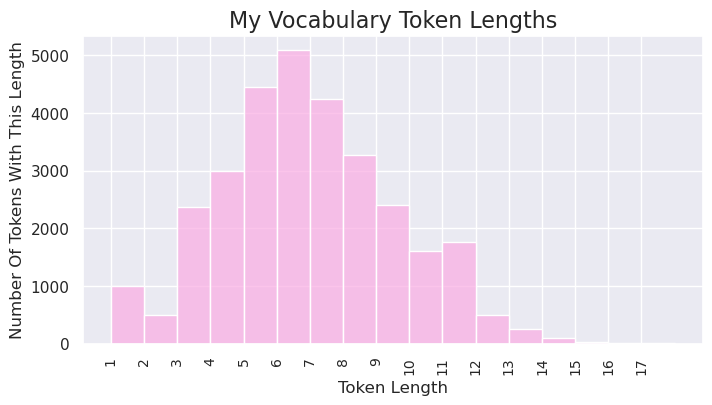

In [56]:
tokens = tokenizer1.vocab.keys()
token_lengths = [len(token) for token in tokens]
print('Maximum token length:', max(token_lengths))
Plot_length(token_lengths, color = palette_color[-4])

### <font color = 'green'>(2) Present the tokenization results for the selected tokenizer on three examples.

In [57]:
print_exmples(train_texts, n=3, tokenizer = tokenizer1)


------------------------------- Sentence (0) has 5 tokens ------------------------------- 
Original :  i did not feel humiliated
Tokenized:  ['i', 'did', 'not', 'feel', 'humiliated']
Token IDs:  [101, 1045, 2106, 2025, 2514, 26608, 102]

------------------------------- Sentence (1) has 21 tokens ------------------------------- 
Original :  i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Tokenized:  ['i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake']
Token IDs:  [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]

------------------------------- Sentence (2) has 11 tokens ------------------------------- 
Original :  i am grabbing a minute to post i feel greedy wrong
Tokenized:  ['i', 'am', 'grabbing', 'a', 'minute', 'to'

In [58]:
print_exmples(val_texts, n=3, tokenizer = tokenizer1)


------------------------------- Sentence (0) has 17 tokens ------------------------------- 
Original :  i am feeling quite sad and sorry for myself but i will snap out of it soon
Tokenized:  ['i', 'am', 'feeling', 'quite', 'sad', 'and', 'sorry', 'for', 'myself', 'but', 'i', 'will', 'snap', 'out', 'of', 'it', 'soon']
Token IDs:  [101, 1045, 2572, 3110, 3243, 6517, 1998, 3374, 2005, 2870, 2021, 1045, 2097, 10245, 2041, 1997, 2009, 2574, 102]

------------------------------- Sentence (1) has 15 tokens ------------------------------- 
Original :  i feel like i am still looking at a blank canvas blank pieces of paper
Tokenized:  ['i', 'feel', 'like', 'i', 'am', 'still', 'looking', 'at', 'a', 'blank', 'canvas', 'blank', 'pieces', 'of', 'paper']
Token IDs:  [101, 1045, 2514, 2066, 1045, 2572, 2145, 2559, 2012, 1037, 8744, 10683, 8744, 4109, 1997, 3259, 102]

------------------------------- Sentence (2) has 6 tokens ------------------------------- 
Original :  i feel like a faithful servant
T

In [59]:
print_exmples(test_texts, n=3, tokenizer = tokenizer1)


------------------------------- Sentence (0) has 13 tokens ------------------------------- 
Original :  i am feeling rather rotten so i am not very ambitious right now
Tokenized:  ['i', 'am', 'feeling', 'rather', 'rotten', 'so', 'i', 'am', 'not', 'very', 'ambitious', 'right', 'now']
Token IDs:  [101, 1045, 2572, 3110, 2738, 11083, 2061, 1045, 2572, 2025, 2200, 12479, 2157, 2085, 102]

------------------------------- Sentence (1) has 10 tokens ------------------------------- 
Original :  i am updating my blog because i feel shitty
Tokenized:  ['i', 'am', 'up', '##dating', 'my', 'blog', 'because', 'i', 'feel', 'shitty']
Token IDs:  [101, 1045, 2572, 2039, 16616, 2026, 9927, 2138, 1045, 2514, 28543, 102]

------------------------------- Sentence (2) has 22 tokens ------------------------------- 
Original :  i never make her separate from me because i don not ever want her to feel like i am ashamed with her
Tokenized:  ['i', 'never', 'make', 'her', 'separate', 'from', 'me', 'because', 'i'

##  Tokenization Using `bert-large-uncased`

In [60]:
model2 = 'bert-large-uncased'
tokenizer2 = BertTokenizer.from_pretrained(model2, do_lower_case=True)
tokenizer2

BertTokenizer(name_or_path='bert-large-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

### <font color = 'green'>(1) Report the tokenizer's vocabulary size.

In [61]:
print(f"`{model2}` vocabulary size is {tokenizer2.vocab_size} token (unique word).")

`bert-large-uncased` vocabulary size is 30522 token (unique word).


Maximum token length: 18


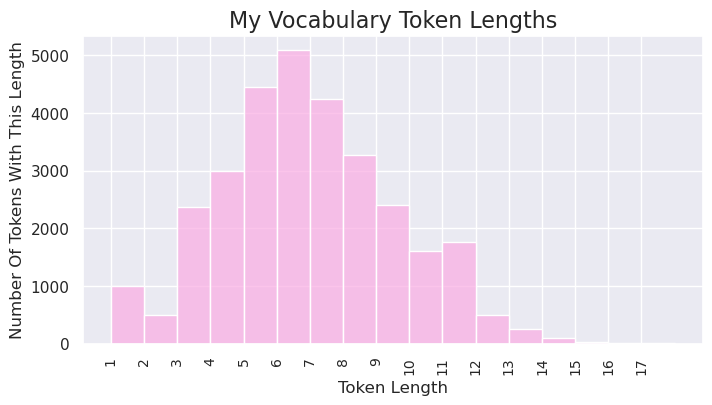

In [62]:
tokens = tokenizer2.vocab.keys()
token_lengths = [len(token) for token in tokens]
print('Maximum token length:', max(token_lengths))
Plot_length(token_lengths, color = palette_color[-4])

### <font color = 'green'>(2) Present the tokenization results for the selected tokenizer on three examples.

In [63]:
print_exmples(train_texts, n=3, tokenizer = tokenizer2)


------------------------------- Sentence (0) has 5 tokens ------------------------------- 
Original :  i did not feel humiliated
Tokenized:  ['i', 'did', 'not', 'feel', 'humiliated']
Token IDs:  [101, 1045, 2106, 2025, 2514, 26608, 102]

------------------------------- Sentence (1) has 21 tokens ------------------------------- 
Original :  i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Tokenized:  ['i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake']
Token IDs:  [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]

------------------------------- Sentence (2) has 11 tokens ------------------------------- 
Original :  i am grabbing a minute to post i feel greedy wrong
Tokenized:  ['i', 'am', 'grabbing', 'a', 'minute', 'to'

In [64]:
print_exmples(val_texts, n=3, tokenizer = tokenizer2)


------------------------------- Sentence (0) has 17 tokens ------------------------------- 
Original :  i am feeling quite sad and sorry for myself but i will snap out of it soon
Tokenized:  ['i', 'am', 'feeling', 'quite', 'sad', 'and', 'sorry', 'for', 'myself', 'but', 'i', 'will', 'snap', 'out', 'of', 'it', 'soon']
Token IDs:  [101, 1045, 2572, 3110, 3243, 6517, 1998, 3374, 2005, 2870, 2021, 1045, 2097, 10245, 2041, 1997, 2009, 2574, 102]

------------------------------- Sentence (1) has 15 tokens ------------------------------- 
Original :  i feel like i am still looking at a blank canvas blank pieces of paper
Tokenized:  ['i', 'feel', 'like', 'i', 'am', 'still', 'looking', 'at', 'a', 'blank', 'canvas', 'blank', 'pieces', 'of', 'paper']
Token IDs:  [101, 1045, 2514, 2066, 1045, 2572, 2145, 2559, 2012, 1037, 8744, 10683, 8744, 4109, 1997, 3259, 102]

------------------------------- Sentence (2) has 6 tokens ------------------------------- 
Original :  i feel like a faithful servant
T

In [65]:
print_exmples(test_texts, n=3, tokenizer = tokenizer2)


------------------------------- Sentence (0) has 13 tokens ------------------------------- 
Original :  i am feeling rather rotten so i am not very ambitious right now
Tokenized:  ['i', 'am', 'feeling', 'rather', 'rotten', 'so', 'i', 'am', 'not', 'very', 'ambitious', 'right', 'now']
Token IDs:  [101, 1045, 2572, 3110, 2738, 11083, 2061, 1045, 2572, 2025, 2200, 12479, 2157, 2085, 102]

------------------------------- Sentence (1) has 10 tokens ------------------------------- 
Original :  i am updating my blog because i feel shitty
Tokenized:  ['i', 'am', 'up', '##dating', 'my', 'blog', 'because', 'i', 'feel', 'shitty']
Token IDs:  [101, 1045, 2572, 2039, 16616, 2026, 9927, 2138, 1045, 2514, 28543, 102]

------------------------------- Sentence (2) has 22 tokens ------------------------------- 
Original :  i never make her separate from me because i don not ever want her to feel like i am ashamed with her
Tokenized:  ['i', 'never', 'make', 'her', 'separate', 'from', 'me', 'because', 'i'

<a ><font size="3"><b>OBSERVATION:</b></font></a>
> Same encoding of the previous tokenizer.

### Choose `max_length`

In [66]:
all_texts = np.concatenate((test_texts, train_texts, val_texts))
samples_length = []
for sent in all_texts:
    input_ids = tokenizer1.encode(sent, add_special_tokens=True)
    samples_length.append(len(input_ids))

Maximum number of tokens in all the samples: 87


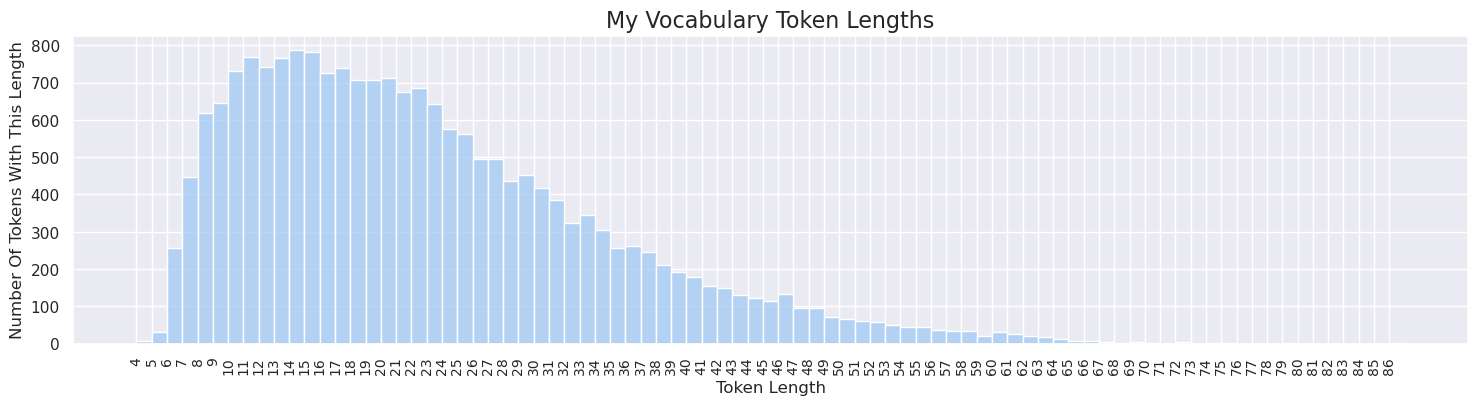

In [67]:
print('Maximum number of tokens in all the samples:', max(samples_length))
Plot_length(samples_length, color = palette_color[0], figsize=(18,4))

<a ><font size="3"><b>OBSERVATION:</b></font></a>
> From the blue graph above, the it seems that choose MAX_LEN with 50 is suitable.

---
## Summarize your answers to Q2 below, based on the analysis:
---
### <font color = 'green'>(1) Report the tokenizer's vocabulary size.
- `bert-base-uncased` vocabulary size is 30522 token (unique word).
- `bert-large-uncased` vocabulary size is 30522 token (unique word).

### <font color = 'green'>(2) Present the tokenization results for the selected tokenizer on three examples.
The results shown in the above section

---
# QUESTION 3: Fine-Tuning
---
 Use one pretrained model offered by Huggingface, e.g., 'distilbert-base-uncased' to train a emotion classification model from train and report their performances on the validation dataset, in terms of accuracy, F1 score, precision and recall.
 
 > I will use `bert-base-uncased` tokenizer that pretrained on 12 encoders (transformer layers)


### Helper Functions

In [68]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [69]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [70]:
set_seed(42)

In [71]:
# Plot the learning curve.
def plot(accuracy, i):
    plt.figure(figsize=(10,4))
    plt.plot(accuracy, '-',color=palette_color[0])

    # Label the plot.
    plt.title(f"Model Accuracy in epoch {i} over batchs")
    plt.xlabel("Batch")
    plt.ylabel("Accuracy")

    plt.show()

## BERT Tokenization

Tokenize all of the sentences and map the tokens to thier word IDs using `encode_plus`, For every sentence :
##### (1) Tokenize the sentence.
##### (2) Prepend the `[CLS]` token to the start.
##### (3) Append the `[SEP]` token to the end.
##### (4) Map tokens to their IDs.
##### (5) Pad or truncate the sentence to `max_length`
##### (6) Create attention masks for `[PAD]` tokens.

In [72]:
# Credit: Tutorial 3 part 2
def Preprocessing_for_bert(data, MAX_LEN = 64, tokenizer=tokenizer1):
    """
    Perform required preprocessing steps for pretrained BERT.
    Arg:
        data (list): List of texts to be processed.
    Return:
        input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
        attention_masks (torch.Tensor): Tensor of indices specifying which tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text= sent, 
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            padding = 'max_length',         # Pad sentence to max length
            truncation=True,
#             return_tensors='pt',            # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [73]:
MAX_LEN = 50

In [74]:
print('Tokenizing Training Data 😴😴😴')
train_inputs, train_masks = Preprocessing_for_bert(train_texts, MAX_LEN, tokenizer=tokenizer1)
print('Tokenizing Validation Data 😴😴😴')
val_inputs, val_masks = Preprocessing_for_bert(val_texts, MAX_LEN, tokenizer=tokenizer1)
print('Tokenizing Testing Data😴😴😴')
test_inputs, test_masks = Preprocessing_for_bert(test_texts,MAX_LEN, tokenizer=tokenizer1)

Tokenizing Training Data 😴😴😴
Tokenizing Validation Data 😴😴😴
Tokenizing Testing Data😴😴😴


In [75]:
train_inputs[0]

tensor([  101,  1045,  2106,  2025,  2514, 26608,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

## Create DataLoader

In [76]:
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our testing set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Model Building
I will use `BertForSequenceClassification`. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier.

In [77]:
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        Args:
            bert: a BertModel object
            classifier: a torch.nn.Module classifier
            freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H1, H2, D_out = 768, 128, 64, 6

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        Args:
            input_ids (torch.Tensor): an input tensor with shape (batch_size, max_length)
            attention_mask (torch.Tensor): a tensor that hold attention mask information with shape (batch_size, max_length)
            logits (torch.Tensor): an output tensor with shape (batch_size, num_labels)
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

## Optimizer & Learning Rate Scheduler

In [78]:
def Initalize_classifier(LR, EPOCHS=4):
    bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=LR,    # Default learning rate is 5e-5
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * EPOCHS

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier,optimizer, scheduler

## Training Loop
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

## Evalution:

- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

In [79]:
from sklearn.metrics import precision_recall_fscore_support
def Evaluation(model, dataloader, dataset = 'Validation'):

    model.eval()
    accuracy = []
    f1_score = []
    precision = []
    recall = []
    total_loss = 0
    
    for batch in dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        # Compute loss
        loss = LOSS_FUNC(logits, b_labels)
        total_loss += loss.item()

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        acc = (preds == b_labels).cpu().numpy().mean() * 100
        accuracy.append(acc)
        
        precision, recall, f1_score, _ = precision_recall_fscore_support(b_labels.cpu().numpy(), 
                                                                         preds.cpu().numpy(),
                                                                         zero_division=1, average='weighted')

    # Compute the average accuracy and loss over the validation set.
    avg_loss = total_loss / len(dataloader)
    avg_acc = np.mean(accuracy)
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1_score = np.mean(f1_score)

    performance_stats = {
        f'{dataset}_Loss': avg_loss,
        f'{dataset}_Accuracy': avg_acc,
        f'{dataset}_Precsion': avg_precision,
        f'{dataset}_Recall': avg_recall,
        f'{dataset}_F1_score':avg_f1_score,
    }
    return performance_stats

In [80]:
def train(model, train_dataloader, val_dataloader=None, evaluate = False, epochs=4):
    epochs_stats = dict()    
    for epoch_i in range(epochs):
        
        print("="*72)
        print(f"{f'Training Epoch {epoch_i+1} on Training data':^72}")
        print("="*72)
        print("-"*72)
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Accuracy(%)':^14} | {'Elapsed Time(sec)':^9}")
        print("-"*72)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        batch_acc = []
        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            
            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = LOSS_FUNC(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            
            # Calculate the accuracy rate 
            preds = torch.argmax(logits, dim=1).flatten()
            acc = (preds == b_labels).cpu().numpy().mean() * 100
            batch_acc.append(acc)
            # Perform a backward pass to calculate gradients
            loss.backward()
            
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 32 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {acc:^17.2f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        
       

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_acc = np.array(batch_acc).mean() 
        time_elapsed = time.time() - t0_epoch
        epochs_stats={
                'Epoch': epoch_i + 1,
                'Training_Loss': avg_train_loss,
                'Training_Accuracy': avg_train_acc,
                'Training_Time': time_elapsed,
        }

        print("-"*72)
        print(f"{'Agg':^7} | {'-':^7} | {avg_train_loss:^12.6f} | {avg_train_acc:^17.2f} | {time_elapsed:^9.2f}")
        if evaluate:
            print("="*72)
            print(f"{f'Evaluating {epoch_i+1} on Validation data':^72}")
            epochs_stats.update(Evaluation(model, val_dataloader, dataset = 'Validation'))
            print("="*72)
            print(f"{'Epoch':^7}|{'Loss':^7}|{'Accuracy(%)':^13}|{'Precsion':^12}|{'Recall':^12}|{'F1-score':^12}")
            print("-"*72)
            print(f"{f'Avg {epoch_i+1}':^7}|{epochs_stats['Validation_Loss']:^7.2f}|{epochs_stats['Validation_Accuracy']:^13.2f}|{epochs_stats['Validation_Precsion']:^12.2f}|{epochs_stats['Validation_Recall']:^12.2f}|{epochs_stats['Validation_F1_score']:^12.2f}")
        print("\n")
        # plot loss and accuracy for batchs 
        plot(batch_acc, epoch_i + 1)
    print("Training complete!")
    return epochs_stats

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch i

                   Training Epoch 1 on Training data                    
------------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  | Train Accuracy(%) | Elapsed Time(sec)
------------------------------------------------------------------------
   1    |   32    |   1.742948   |       34.38       |   3.76   
   1    |   64    |   1.641550   |       46.88       |   2.97   
   1    |   96    |   1.481540   |       46.88       |   2.97   
   1    |   128   |   1.371040   |       62.50       |   2.98   
   1    |   160   |   1.289006   |       53.12       |   2.98   
   1    |   192   |   1.173165   |       71.88       |   2.99   
   1    |   224   |   1.068422   |       78.12       |   3.00   
   1    |   256   |   0.974989   |       78.12       |   3.00   
   1    |   288   |   0.855300   |       87.50       |   3.01   
   1    |   320   |   0.848385   |       78.12       |   3.01   
   1    |   352   |   0.804675   |       84.38       |   3

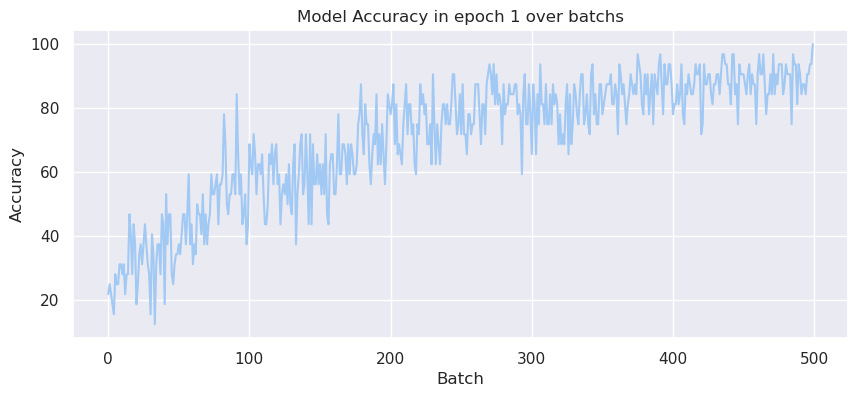

                   Training Epoch 2 on Training data                    
------------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  | Train Accuracy(%) | Elapsed Time(sec)
------------------------------------------------------------------------
   2    |   32    |   0.496489   |       96.88       |   3.11   
   2    |   64    |   0.475013   |       81.25       |   3.02   
   2    |   96    |   0.427849   |       90.62       |   3.03   
   2    |   128   |   0.438641   |       90.62       |   3.03   
   2    |   160   |   0.406575   |       96.88       |   3.03   
   2    |   192   |   0.389621   |       84.38       |   3.03   
   2    |   224   |   0.344360   |       87.50       |   3.03   
   2    |   256   |   0.330255   |      100.00       |   3.03   
   2    |   288   |   0.347931   |      100.00       |   3.03   
   2    |   320   |   0.322812   |       90.62       |   3.03   
   2    |   352   |   0.308510   |       90.62       |   3

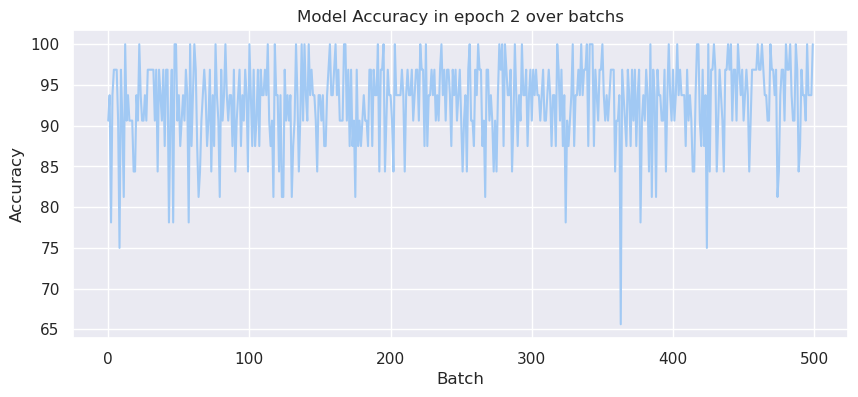

                   Training Epoch 3 on Training data                    
------------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  | Train Accuracy(%) | Elapsed Time(sec)
------------------------------------------------------------------------
   3    |   32    |   0.245495   |       96.88       |   3.14   
   3    |   64    |   0.253175   |       96.88       |   3.04   
   3    |   96    |   0.223662   |       93.75       |   3.04   
   3    |   128   |   0.242714   |       90.62       |   3.05   
   3    |   160   |   0.230956   |       93.75       |   3.05   
   3    |   192   |   0.255510   |       87.50       |   3.05   


In [ ]:
EPOCHS = 3
LR = 2e-5
LOSS_FUNC = nn.CrossEntropyLoss()

bert_classifier,optimizer, scheduler = Initalize_classifier(LR, EPOCHS)
performance_stats = train(bert_classifier, train_dataloader,val_dataloader, evaluate = True, epochs=EPOCHS)

In [ ]:
performance_stats.update(Evaluation(bert_classifier, test_dataloader, dataset = 'Testing'))

In [ ]:
stats_df = pd.DataFrame(columns = ['Loss', 'Accuracy', 'Precsion', 'Recall', 'F1_score', 'Time'], index = ['Training', 'Validation', 'Testing'])

for k, v in performance_stats.items():
    for col in stats_df.columns:
        for idx in stats_df.index:
            if k.startswith(idx) and k.endswith(col):
                 stats_df.loc[idx, col]=v
stats_df = stats_df.replace({np.nan: '-'})
stats_df

---
## Summarize your answers to Q3 below, based on the analysis:

---

Based on the updated the provided results:
- The model appears to be performing well, with high accuracy on both the training, validation and testing sets.
- The loss is decreasing from the training set to the testing set, which is a good sign that the model is generalizing well to new data.
- The precision and recall values for the validation set suggest that the model is performing well at correctly identifying positive examples for all six classes, with a high precision value indicating that a high percentage of the predicted positive examples are correct, and a high recall value indicating that the model is correctly identifying a high percentage of the actual positive examples for all classes.

- The F1-score is reported for all sets, with high values for all six classes indicating that the model is performing well at both identifying positive examples and correctly classifying negative examples for all classes.

- The training time is very low, as we are only fine-tuning the model rather than training it from scratch, and with the aid of the GPU.

> I changed the number of layers in the classifier layer, but the results show that the current layers is the best one.